# Compute the number of generations since admixture from admixture tract lengths

In [1]:
import numpy as np
import patsy as ps
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set()
sns.set_style('ticks')

In [12]:
def length_to_windows(length_df, window_size=100000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.paint_length)//window_size
            if x == 0:
                overall_dict[row["pop"]][i] += int(row.paint_length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["pop"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["pop"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["pop"]][i+x] += int(row.paint_length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile, haploid=False):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    if haploid==False:
        h = 2
    else:
        h = 1
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*h+1] = row["pop"]
        map_dict[row.ID_index*h+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            if haploid==False:
                if hap == 1:
                    hap = 2
                else:
                    hap = 1
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

### Generate some dummy exponentially distributed length data

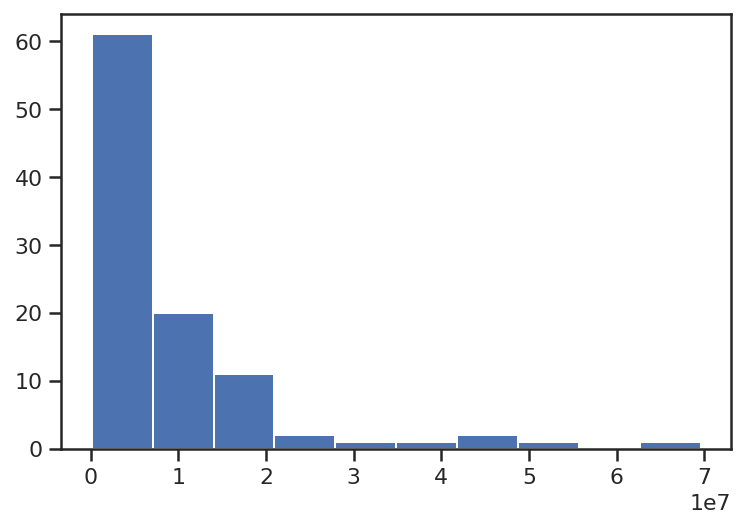

In [2]:
# dummy length data
from numpy.random import exponential
phys_lengths = exponential(scale=10000000, size=100) #+ 50000000
plt.hist(phys_lengths) ;

In [3]:
mean_rec_rate = 1e-8
lengths = phys_lengths * mean_rec_rate

### Compute the empirical CDF

In [4]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

val, prob = ecdf(lengths)

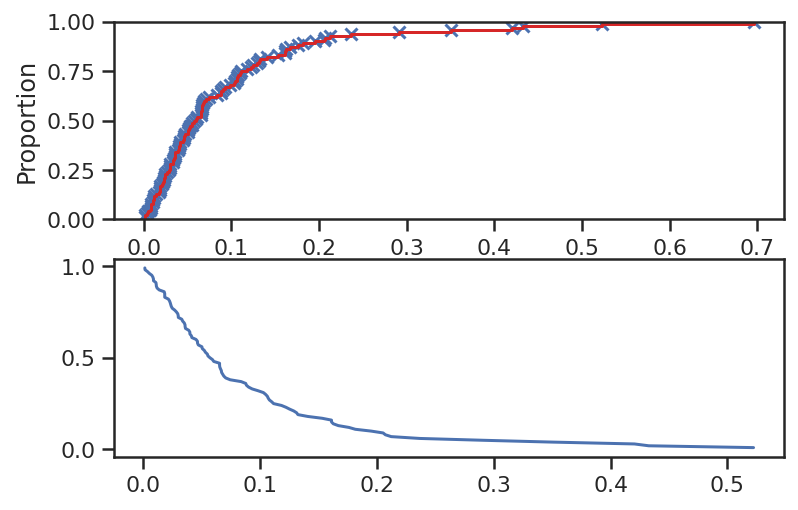

In [5]:
plt.subplot(211)
plt.scatter(val, prob, marker='x')
# sanity check
sns.ecdfplot(x=val, color='tab:red') 

# PDF
plt.subplot(212)
d, p = val[:-1], 1-prob[:-1] # leave out last one to avoid division by zero
plt.plot(d, p) ;

### Estimate the number of generations

The admixture is likely not the result of a single admixture event, but if we assume that it is, the length distribution of tracts is well approximated by $y=Ae^{−(n−1)d}$. Here $n$ is the number of generations since the admixture event and $d$ is genetic distance (physical length times mean recombination rate per base) and $A$ is a scaling factor. We fit a line to the log of the complementary cummulative distribution (the PDF) of tract lengths and, since $\ln(y)=−(n−1)d+\ln(A)$, the slope of the fitted line is n−1.

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


Intercept   -0.128598
d           -9.721376
dtype: float64

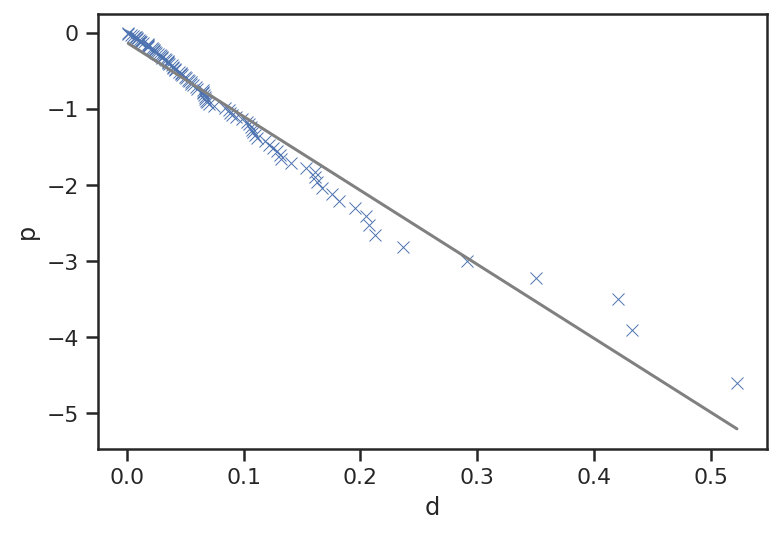

In [6]:
# mask = ~np.isnan(x)
# df = pd.DataFrame(dict(d=d[mask], p=np.log(1-p[mask])))

df = pd.DataFrame(dict(d=d, p=np.log(p)))

y, X = ps.dmatrices('p ~ d',data = df, return_type = 'dataframe')
model = sm.OLS(y,X)
results = model.fit()
predicted_p = results.predict()
p_residuals = df.p - predicted_p

ax = sns.scatterplot(x=df.d, y=df.p, marker='x');
ax.plot(df.d, predicted_p, color='grey', marker=None);
results.params

Generations since admixture pulse is:

In [7]:
round(-results.params.d + 1)

11

Repeating for the interesting individuals - Possibly chrX for the Tarangire, and multiple autosomes for Issa Valley.

In [8]:
length_df_chrX_males = pd.read_csv("../steps/paint_summary/"+"length_df_chrX_males", sep=" ")

Assumption: Admixture can be well described as Northern ancestry versus southern ancestry.
In this case, this is probably close to the truth, as the ancestral background very clearly is olive, while the most recently admixing population is hamadryas.

In [10]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [88]:
idfile_path = "/home/eriks/baboondiversity/data/haploidified_chrX_males/idfile_males_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile = idfile.loc[idfile.inclusion == 1]
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin
c_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    c_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]
length_df_chrX_males["population"] = length_df_chrX_males["individual"].map(mapping)
length_df_chrX_males["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in length_df_chrX_males.chrom] # Some are read as int
horizon_list = []
meta_data_list = meta_data_samples.loc[(meta_data_samples.Origin == "Tarangire, Tanzania") & (meta_data_samples.Sex == "M")].PGDP_ID
for ind in meta_data_list:
    temp_horizon = length_to_windows(length_df_chrX_males.loc[(length_df_chrX_males.individual == ind)
                                                              & (length_df_chrX_males.chrom == "chrX")], window_size=10000)
    temp_horizon["PGDP_ID"] = ind
    temp_horizon["chrom"] = "chrX"
    horizon_list.append(temp_horizon)
group_horizon = pd.concat(horizon_list)

In [109]:
input_df = group_horizon.loc[group_horizon.PGDP_ID == "PD_0642"]
input_df["north"] = input_df.Anubis_Ethiopia+input_df.Hamadryas_Ethiopia+input_df.Papio_Senegal#+a_c_df.anubis_tanzania
input_df["norm_north"] = ((input_df.north-input_df.iloc[:,1:7].sum(axis=1))/2)
input_df["pop"] = input_df["PGDP_ID"].map(mapping)
input_df["start"] = input_df["windows"]
input_df["N_S"] = ["North" if x >= 0 else "South" for x in input_df["norm_north"]]
shift_spots = (input_df["N_S"] != input_df["N_S"].shift())
spot_df = input_df.loc[shift_spots].copy()
spot_df["paint_length"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-spot_df["windows"].values)
spot_df["end_pos"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-1)
a_c_df = spot_df

<ipython-input-109-306267d6d9cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df["north"] = input_df.Anubis_Ethiopia+input_df.Hamadryas_Ethiopia+input_df.Papio_Senegal#+a_c_df.anubis_tanzania
<ipython-input-109-306267d6d9cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df["norm_north"] = ((input_df.north-input_df.iloc[:,1:7].sum(axis=1))/2)
<ipython-input-109-306267d6d9cf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [110]:
input_df

,windows,Anubis_Ethiopia,Cynocephalus_Central_Tanzania,Cynocephalus_Western_Tanzania,Hamadryas_Ethiopia,Kindae_Zambia,Papio_Senegal,Ursinus_Zambia,PGDP_ID,chrom,north,norm_north,pop,start,N_S
0,216,28430.0,52283.0,31127.0,19647.0,7580.0,20933.0,0.0,PD_0642,chrX,69010.0,-45495.0,"Tarangire, Tanzania",216,South
1,10216,30658.0,38491.0,39440.0,13353.0,8337.0,29721.0,0.0,PD_0642,chrX,73732.0,-43134.0,"Tarangire, Tanzania",10216,South
2,20216,13875.0,63979.0,20555.0,14044.0,31660.0,15887.0,0.0,PD_0642,chrX,43806.0,-58097.0,"Tarangire, Tanzania",20216,South
3,30216,41798.0,45055.0,17375.0,15772.0,40000.0,0.0,0.0,PD_0642,chrX,57570.0,-51215.0,"Tarangire, Tanzania",30216,South
4,40216,69341.0,54178.0,2590.0,6461.0,27430.0,0.0,0.0,PD_0642,chrX,75802.0,-42099.0,"Tarangire, Tanzania",40216,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14364,143640216,0.0,0.0,0.0,160000.0,0.0,0.0,0.0,PD_0642,chrX,160000.0,0.0,"Tarangire, Tanzania",143640216,North
14365,143650216,0.0,0.0,0.0,160000.0,0.0,0.0,0.0,PD_0642,chrX,160000.0,0.0,"Tarangire, Tanzania",143650216,North
14366,143660216,0.0,0.0,0.0,160000.0,0.0,0.0,0.0,PD_0642,chrX,160000.0,0.0,"Tarangire, Tanzania",143660216,North
14367,143670216,9134.0,23703.0,0.0,125065.0,2098.0,0.0,0.0,PD_0642,chrX,134199.0,-12900.5,"Tarangire, Tanzania",143670216,South


Loading mean rec rate

In [111]:
rec_file_path = "ldhat_conversion_chr{}_updated.txt"
dir_path = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/"
chrom = "X"
rec_file = pd.read_csv(dir_path+rec_file_path.format(chrom), sep=" ")

In [112]:
mean_rec = rec_file.iloc[-2]["Genetic_Map(cM)"]/rec_file.iloc[-2]["position"]

In [113]:
lengths = a_c_df.loc[a_c_df.N_S == "South"].paint_length*mean_rec

In [120]:
val, prob = ecdf(lengths.loc[lengths > 0.1])

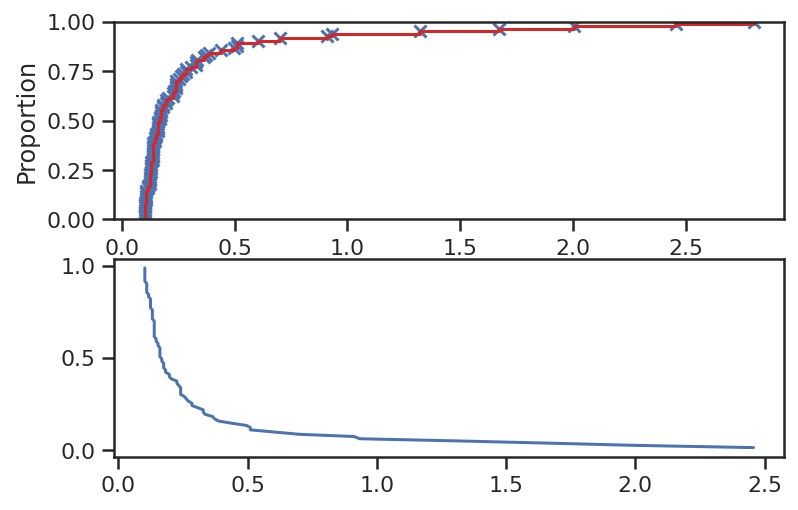

In [121]:
plt.subplot(211)
plt.scatter(val, prob, marker='x')
# sanity check
sns.ecdfplot(x=val, color='tab:red') 

# PDF
plt.subplot(212)
d, p = val[:-1], 1-prob[:-1] # leave out last one to avoid division by zero
plt.plot(d, p) ;

/home/eriks/miniconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


Intercept   -0.350902
d           -2.036925
dtype: float64

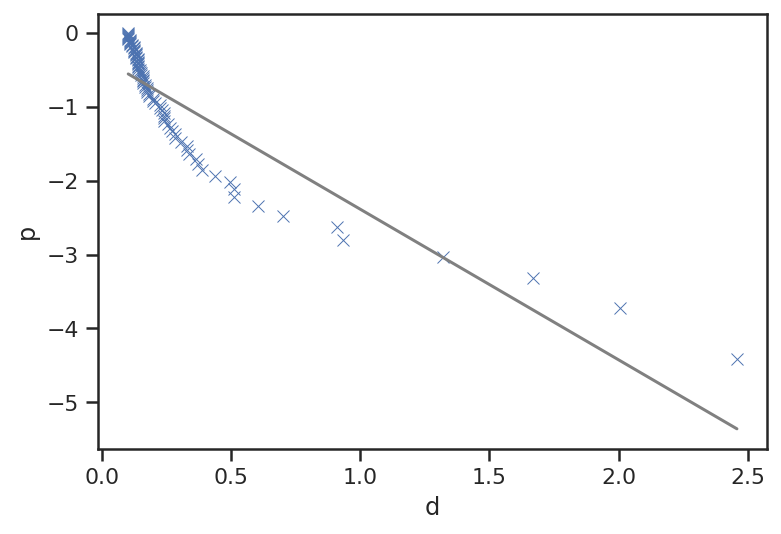

In [122]:
df = pd.DataFrame(dict(d=d, p=np.log(p)))

y, X = ps.dmatrices('p ~ d',data = df, return_type = 'dataframe')
model = sm.OLS(y,X)
results = model.fit()
predicted_p = results.predict()
p_residuals = df.p - predicted_p

ax = sns.scatterplot(x=df.d, y=df.p, marker='x');
ax.plot(df.d, predicted_p, color='grey', marker=None);
results.params

In [130]:
print(results.conf_int(0.025))

                  0         1
Intercept -0.484422 -0.217382
d         -2.302440 -1.771411


In [123]:
round(-results.params.d + 1)

3

In [124]:
low, high = results.conf_int(0.025).loc['d']
f"{round(-(results.params.d + 1))} 95% conf: {round(-(high+1))} - {round(-(low+1))}"

'1 95% conf: 1 - 1'